In [2]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc
import seaborn as sns

# %load_ext nb_black
use_cuda = True
sc.set_figure_params(dpi=200)

In [3]:
import sys
sys.path.append('/home/angela/src/scVI_TSP/')
sys.path.append('/home/angela/sapiens/tabula-sapiens/')
# from utils.annotations_utils import *
from utils.colorDict import *
from utils.general_utils import *
from utils.plotting_utils import *

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
data_path = "/mnt/ibm_lg/angela/sapiens/data/"

In [6]:
adata = read_h5ad(data_path + "Pilot1_Pilot2.decontX.h5ad")
adata

AnnData object with n_obs × n_vars = 150084 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_metho

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


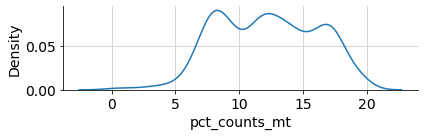

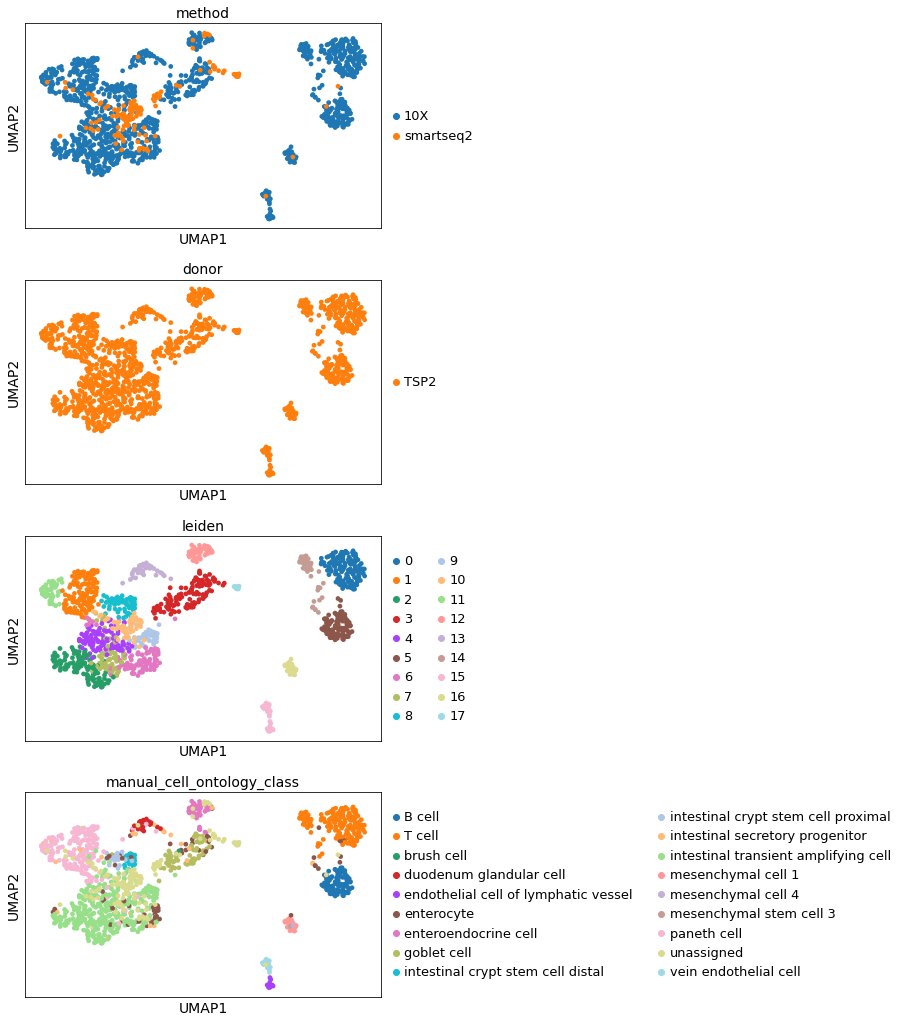

In [36]:
organ = "Small_Intestine"
organ_adata = adata[adata.obs["tissue"] == organ]

organ_adata.var['mt'] = organ_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(organ_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sns.displot(data=organ_adata.obs, x="pct_counts_mt", kind="kde", height=2, aspect=3)

sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=1)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [37]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

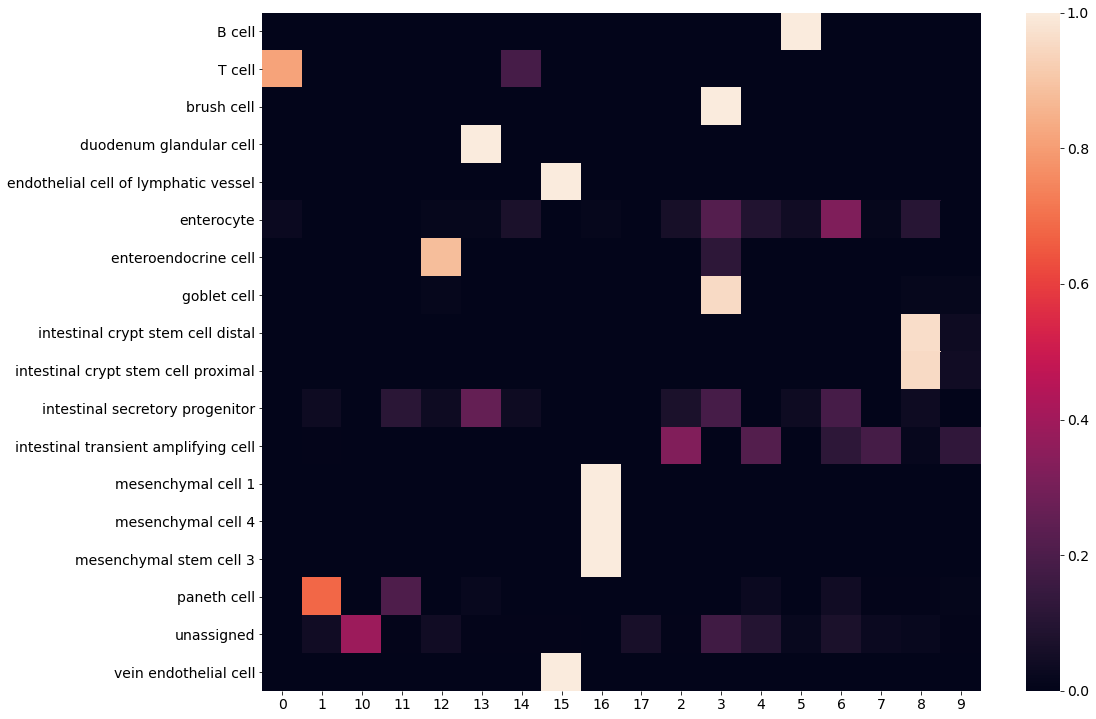

In [38]:
import seaborn

plt.figure(figsize=(16, 12))
seaborn.heatmap((count.T / count.sum(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [39]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [40]:
cluster_composition["0"]

['T cell: 0.99', 'enterocyte: 0.01']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [41]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [42]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [43]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


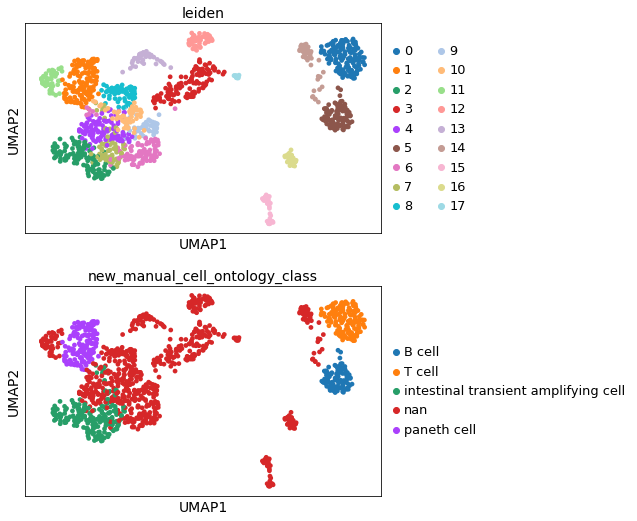

In [44]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

In [45]:
organ_adata.obs.groupby(["leiden"]).agg(
    {"new_manual_cell_ontology_class": set, "Propagated.Annotation": set}
)

,new_manual_cell_ontology_class,Propagated.Annotation
leiden,,
0,{T cell},{T cell}
1,{paneth cell},"{intestinal transient amplifying cell, intesti..."
2,{intestinal transient amplifying cell},"{intestinal transient amplifying cell, intesti..."
3,{nan},"{brush cell, cell, paneth cell, B cell, goblet..."
4,{nan},"{intestinal crypt stem cell proximal, intestin..."
5,{B cell},{B cell}
6,{nan},"{goblet cell, intestinal transient amplifying ..."
7,{intestinal transient amplifying cell},"{intestinal crypt stem cell proximal, intestin..."
8,{nan},"{paneth cell, goblet cell, intestinal secretor..."


/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


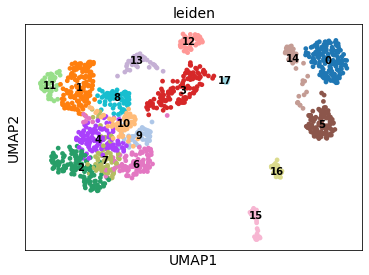

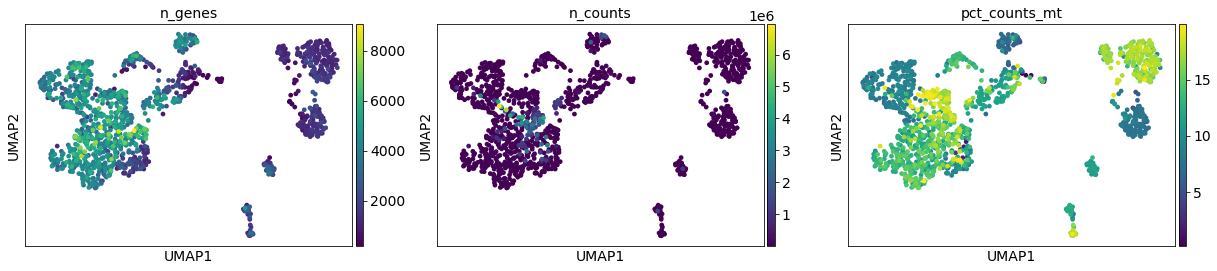

In [46]:
sc.pl.umap(organ_adata, color="leiden", legend_loc="on data")
sc.pl.umap(organ_adata,color=['n_genes','n_counts','pct_counts_mt'])

In [47]:
sc.tl.rank_genes_groups(organ_adata,'leiden',method='wilcoxon')

In [48]:
organ_cluster_genes = pd.DataFrame(organ_adata.uns['rank_genes_groups']['names'])
organ_cluster_genes.iloc[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,CCL5,LYZ,UGT2A3,TFF3,OLFM4,LAPTM5,RBP2,FABP1,CEL,STMN1,EEF1A1P6,CTSE,SCGN,MUC6,IKZF1,VIM,IGFBP6,CSF3R
1,IL7R,AC020656.1,FABP1,FCGBP,DMBT1,CXCR4,GSTA1,HEBP1,RGMB,TUBA1B,EEF1A1,MSMB,PCSK1N,C6orf58,CCL5,CLDN5,IGFBP5,S100A9
2,SRGN,FOXQ1,VNN1,HEPACAM2,REG1A,HLA-DPA1,MT1H,RBP2,OLFM4,TUBB,EEF1A1P5,TSPAN1,CHGB,TFF2,IL7R,PECAM1,DCN,IFITM2
3,CD69,LMO4,SLC51B,HES6,CHP2,GPR183,FABP1,KHK,SLC12A2,PCLAF,DNAJB1,HPGD,NEUROD1,PGC,CD3E,IGFBP7,FBLN1,LCP1
4,CXCR4,VSIG2,CYBRD1,CLCA1,CPS1,CD37,REG1A,ADA,CDK6,TK1,MT-CO1,VSIG2,CHGA,LYZ,CD3G,CAV1,SFRP1,FPR1
5,CD3E,MUC1,SLC5A1,RAB26,MAOA,CD79A,MT1G,GSTA2,ASCL2,SMC2,TSPYL1,FXYD3,KCTD12,AC020656.1,CD3D,CAVIN2,FSTL1,SAT1
6,PTPRC,GP2,MALL,ITLN1,PIGR,CD83,CCL25,AKR7A2,CDCA7,HMGB2,KRT8P3,ANXA10,CACNA1A,AC139749.1,PTPRC,TIMP3,ADH1B,SLA
7,CD3D,ANXA10,RBP2,DLL1,CLDN15,MS4A1,PTGR1,GBA3,EPHB2,H2AFZ,EPCAM,LMO4,SCG5,AQP5,ACAP1,GNG11,MGP,SAMSN1
8,ARHGDIB,GOLM1,GBA3,NEURL1,SLC12A2,SMAP2,OLFM4,UGT2A3,MT-ND3,MAD2L1,TOB1,CA2,SCG3,FMOD,CD8A,VWF,CFD,G0S2
9,CCL4,CTSE,MME,RASD1,MME,TNFRSF13C,MT2A,GSTA1,SOX4,KIF20B,AC008038.1,SLC26A3,NKX2-2,NUCB2,CD2,TGFBR2,C1R,S100A8


In [49]:
g = list(organ_cluster_genes["11"].head(10))
g = ",".join(g)
print(g)

CTSE,MSMB,TSPAN1,HPGD,VSIG2,FXYD3,ANXA10,LMO4,CA2,SLC26A3


In [69]:
set(organ_adata.obs[organ_adata.obs['leiden']=='6']['manual_annotation'])

{'absorptive progenitor',
 'enterocyte',
 'paneth cell',
 'secretory progenitor',
 'transient amplifying cell',
 'unassigned'}

In [67]:
cluster_composition["9"]

['goblet cell: 0.02',
 'intestinal crypt stem cell distal: 0.02',
 'intestinal crypt stem cell proximal: 0.02',
 'intestinal transient amplifying cell: 0.89',
 'paneth cell: 0.04',
 'unassigned: 0.02']

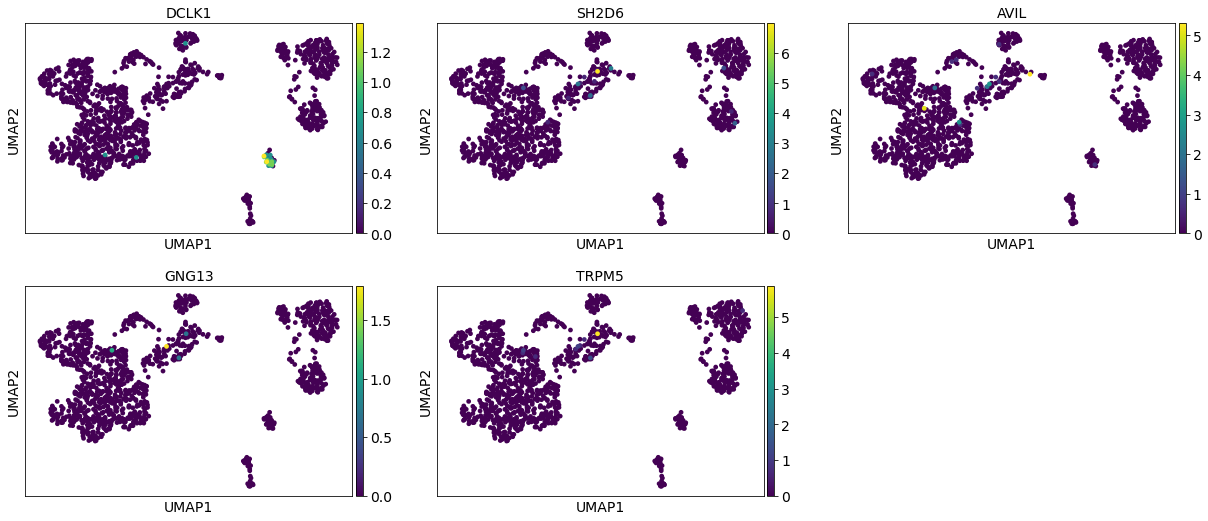

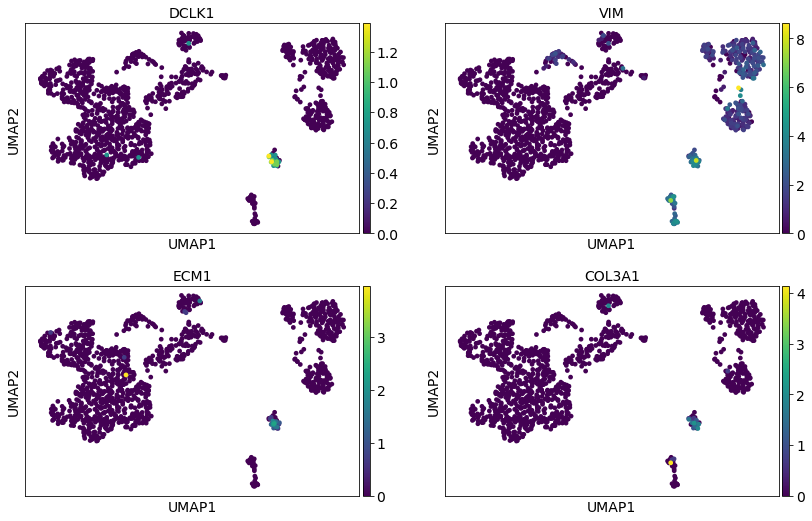

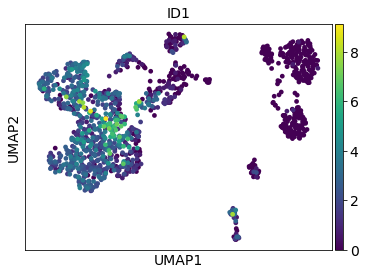

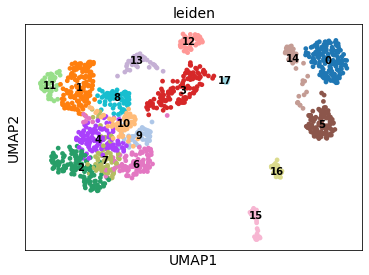

In [87]:
# sc.pl.umap(organ_adata,color=[ 'CD4','CD8A','CD3E','CD79A'],ncols=4) # t cells & b cells
# sc.pl.umap(organ_adata,color=[ 'LGR5', 'ASCL2','OLFM4'],ncols=2) # Stem cells
# sc.pl.umap(organ_adata,color=[ 'ALPI', 'KRT20'],ncols=2) # Enterocyte (absorptive)
# sc.pl.umap(organ_adata,color=[ 'CHGA', 'CHGB', 'CCK','TRPA1','SST','MLN'],ncols=2) # Enteroendocinre cells
# sc.pl.umap(organ_adata,color=[ 'MUC2', 'TFF3', 'ATOH1','HEPACAM2'],ncols=2) # Goblet cells
sc.pl.umap(organ_adata,color=[ 'DCLK1','SH2D6','AVIL', 'GNG13', 'TRPM5'],ncols=3) # tuft cells
# sc.pl.umap(organ_adata,color=[ 'NR2F2','SOX17','GJA5','NOG','ITGA6'],ncols=1) # 
# sc.pl.umap(organ_adata,color=[ 'CD44','CSPG4','PDGFRB', 'ACTA2','MYL9','MYH11'],ncols=2)
sc.pl.umap(organ_adata,color=['DCLK1','VIM','ECM1','COL3A1'],ncols=2)#'fibroblasts
# sc.pl.umap(organ_adata,color=['LYZ','DEFA1','FZD5','EPHB2','DLL1','WNT3','WNT11','EGF'])# paneth cells
sc.pl.umap(organ_adata,color=['ID1'])# transamplifying 
sc.pl.umap(organ_adata,color='leiden',legend_loc='on data')

# sc.pl.umap(organ_adata,color='anatomical_position')

In [71]:
leiden_cell_type = {
    "0": "CD8-positive, alpha-beta T cell",
    "1": "paneth cell",
    "2": "enterocyte of epithelium of small intestine",
    "3": "goblet cell",
    "4": "enterocyte of epithelium of small intestine",
    "5": "B cell",
    "6" : "intestinal transient amplifying cell",
    "7": "enterocyte of epithelium of small intestine",
    "8": "intestinal crypt stem cell", #LGR5 ASCL2 OLFM4
    "9": "intestinal transient amplifying cell",
    "10": "intestinal crypt stem cell", #LGR5 ASCL2 OLFM4
    "11": "paneth cell",
    "12": "intestinal enteroendocrine cell",
    "13": "paneth cell",
    "14": "CD8-positive, alpha-beta T cell",# might need some reannots in the big obj
    "15": "gut endothelial cell",
    "16": "tuft cell", #DCLK1+
    "17": "neutrophil"
}    

# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [72]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()


This cell will automatically replace the leiden cluster names with cell type annotations

In [73]:
for l in leiden_cell_type.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, leiden_cell_type[l], inplace=True)

# Visualize the results of the manual annotation

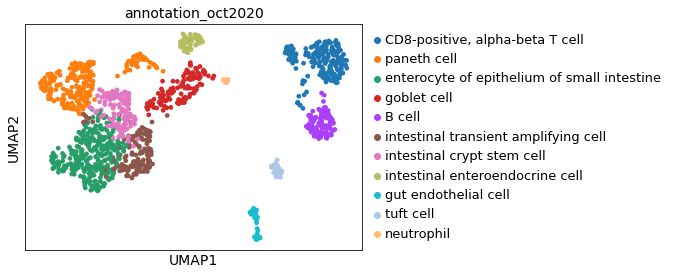

In [74]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# visualize compartment markers

In [75]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [76]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


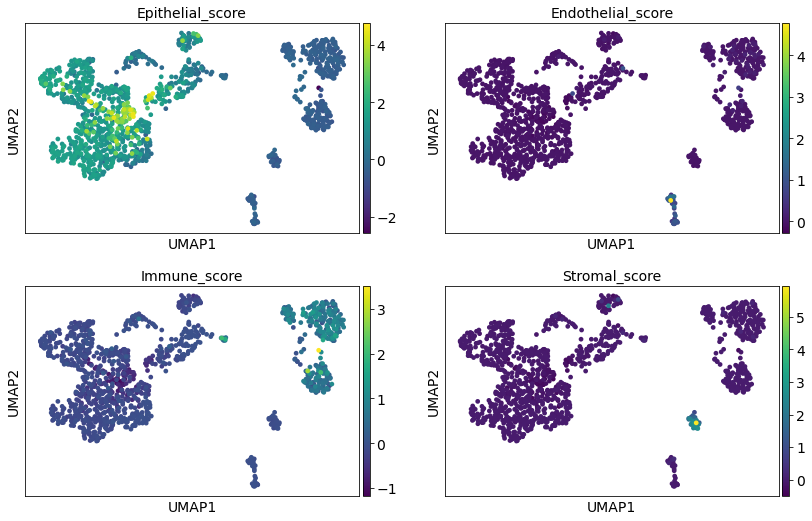

In [89]:
sc.pl.umap(
    organ_adata,ncols=2,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# read in cell ontology 

In [30]:
import obonet

ont_dir = "/data/yosef2/users/chenling/TabulaSapiensData/ontology/"
obo = ont_dir + "cl.obo.txt"
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

celltype_dict = {}
for x in co.nodes:
    celltype_dict[co.nodes[x]['name']] = x



You can look up all T cell by typing celltype_dict['T'] and using tab complete  

In [31]:
celltype_dict["T cell"]

'CL:0000084'

You can also look at the names of all subsets of T cell that contains 'CD4' in their names

In [32]:
import networkx as nx


def PrintChildren(co, parent, pattern=""):
    all_children = [x for x in nx.ancestors(co, celltype_dict[parent])]
    return [co.nodes[x]["name"] for x in all_children if pattern in co.nodes[x]["name"]]


PrintChildren(co, "T cell", "CD4")

['CD4-positive type I NK T cell secreting interleukin-4',
 'CD4-positive, CD8-intermediate double-positive thymocyte',
 'CD4-positive, alpha-beta T cell',
 'activated CD4-positive, alpha-beta T cell',
 'effector memory CD4-positive, alpha-beta T cell',
 'CD4-negative, CD8-negative type I NK T cell secreting interleukin-4',
 'CD4-positive type I NK T cell secreting interferon-gamma',
 'central memory CD4-positive, alpha-beta T cell',
 'CD4-negative, CD8-negative type I NK T cell secreting interferon-gamma',
 'CD2-positive, CD5-positive, CD44-positive alpha-beta intraepithelial T cell',
 'CD69-positive, CD4-positive single-positive thymocyte',
 'CD4-positive type I NK T cell',
 'CD4-intermediate, CD8-positive double-positive thymocyte',
 'activated CD4-positive, alpha-beta T cell, human',
 'activated CD4-positive type I NK T cell',
 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell',
 'mature CD4 single-positive thymoc

# manually create mapping between cell type and compartment (this is just an example)

In [78]:
set(organ_adata.obs['annotation_oct2020'])

{'B cell',
 'CD8-positive, alpha-beta T cell',
 'enterocyte of epithelium of small intestine',
 'goblet cell',
 'gut endothelial cell',
 'intestinal crypt stem cell',
 'intestinal enteroendocrine cell',
 'intestinal transient amplifying cell',
 'neutrophil',
 'paneth cell',
 'tuft cell'}

In [79]:
# options are Immune, Stromal, Epithelial, Endothelial
compartment_mapping = {
    'B cell' : 'Immune',
    'CD8-positive, alpha-beta T cell' : 'Immune',
    'enterocyte of epithelium of small intestine' : 'Epithelial',
    'goblet cell' : 'Epithelial',
    'gut endothelial cell' : 'Endothelial',
    'intestinal crypt stem cell' : 'Epithelial',
    'intestinal enteroendocrine cell' : 'Epithelial',
    'intestinal transient amplifying cell' : 'Epithelial',
    'neutrophil' : 'Immune',
    'paneth cell' : 'Epithelial',
    'tuft cell' : 'Epithelial'
}

In [80]:
organ_adata.obs["compartment_oct2020"] = organ_adata.obs["annotation_oct2020"].copy()

This cell will automatically replace the leiden cluster names with cell type annotations

In [81]:
for c in compartment_mapping.keys():
    organ_adata.obs["compartment_oct2020"].replace(
        c, compartment_mapping[c], inplace=True
    )

# Visualize the results of the new compartment splitting

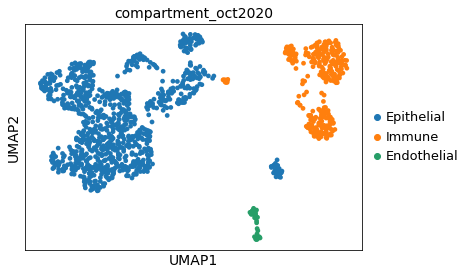

In [82]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# save data

In [83]:
data_path

'/mnt/ibm_lg/angela/sapiens/data/'

In [84]:
organ_adata.write_h5ad(
    data_path + "decontX/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)